# Plotting transcript abundance

In [1]:
# Core
import re, os, glob, sys, string, psutil
import pandas as pd
from pathlib import Path
from itertools import cycle, islice, combinations
import numpy as np
# Plotting
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib import colors, cm
from matplotlib.offsetbox import AnchoredText
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
from helpers import multiTPMplot, tpm_plot, Vividict
# Stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

# _P. amilis_
## Loading the data
### Metadata

In [2]:
rna_sample_data = pd.read_csv("../Data/RNA_samples.csv")
rna_sample_data = rna_sample_data[['RNA_No', 'Collection_time', 'Acc_No']]
sample_names = []
individuals = []
genotypes = []
for i, row in rna_sample_data.iterrows():
    if row["Acc_No"].startswith("AM"):
        sample_name = re.sub("ISG", "P-amilis", row["RNA_No"])
        genotypes.append("P. amilis")
    if row["Acc_No"].startswith("OF"):
        sample_name = re.sub("ISG", "P-oleracea-Florida", row["RNA_No"])
        genotypes.append("P. oleracea F")
    if row["Acc_No"].startswith("OR"):
        sample_name = re.sub("ISG", "P-oleracea-Russia", row["RNA_No"])
        genotypes.append("P. oleracea R")
    sample_names.append(sample_name)   
    individuals.append(row["Acc_No"][2:])
rna_sample_data['sample'] = sample_names
rna_sample_data['individual'] = individuals
rna_sample_data['genotype'] = genotypes
rna_sample_data.head()

,RNA_No,Collection_time,Acc_No,sample,individual,genotype
0,ISG_001,12 February 2019 10:00,OF05,P-oleracea-Florida_001,05,P. oleracea F
1,ISG_002,12 February 2019 10:00,AM01,P-amilis_002,01,P. amilis
2,ISG_003,12 February 2019 10:00,OR06,P-oleracea-Russia_003,06,P. oleracea R
3,ISG_004,12 February 2019 10:00,AM04,P-amilis_004,04,P. amilis
4,ISG_005,12 February 2019 10:00,OF04,P-oleracea-Florida_005,04,P. oleracea F


Now I'll add work with this dataframe a bit for plotting later.

In [3]:
amilis_metadata = rna_sample_data[rna_sample_data["genotype"]==("P. amilis")].reset_index(drop=True)

metadict = Vividict()
time_colors = ['xkcd:pale blue', 'xkcd:pastel blue', 'xkcd:blue', 'xkcd:dark blue', 
               'xkcd:light pink', 'xkcd:dark pink', 'xkcd:light red', 'xkcd:dark red']
time_hexcolors = [colors.to_hex(c) for c in time_colors]
for i,t in enumerate(amilis_metadata['Collection_time'].unique()):
    metadict[t]['color'] = time_colors[i]
    metadict[t]['hex_color'] = time_hexcolors[i]
    metadict[t]['time_point'] = i
    
amilis_metadata['color'] = [metadict[t]['color'] for t in amilis_metadata['Collection_time']]
amilis_metadata['hex_color'] = [metadict[t]['hex_color'] for t in amilis_metadata['Collection_time']]
amilis_metadata['time_point'] = [metadict[t]['time_point'] for t in amilis_metadata['Collection_time']]
amilis_metadata.head()

,RNA_No,Collection_time,Acc_No,sample,individual,genotype,color,hex_color,time_point
0,ISG_002,12 February 2019 10:00,AM01,P-amilis_002,01,P. amilis,xkcd:pale blue,#d0fefe,0
1,ISG_004,12 February 2019 10:00,AM04,P-amilis_004,04,P. amilis,xkcd:pale blue,#d0fefe,0
2,ISG_007,12 February 2019 10:00,AM02,P-amilis_007,02,P. amilis,xkcd:pale blue,#d0fefe,0
3,ISG_009,12 February 2019 10:00,AM05,P-amilis_009,05,P. amilis,xkcd:pale blue,#d0fefe,0
4,ISG_010,12 February 2019 10:00,AM03,P-amilis_010,03,P. amilis,xkcd:pale blue,#d0fefe,0


In [4]:
kallisto_dir = Path("../farnam-drought-diff-exp/Kallisto/Portulaca-amilis/")
amilis_metadata['sequencer_name'] = sorted([i.stem for i in kallisto_dir.iterdir()])
amilis_metadata['treatment'] = ['W' if row['time_point']<4 else 'D' for i,row in amilis_metadata.iterrows()]
amilis_metadata.set_index("sample", inplace=True)
amilis_metadata.head()

,RNA_No,Collection_time,Acc_No,individual,genotype,color,hex_color,time_point,sequencer_name,treatment
sample,,,,,,,,,,
P-amilis_002,ISG_002,12 February 2019 10:00,AM01,01,P. amilis,xkcd:pale blue,#d0fefe,0,P-amilis_002_174_019,W
P-amilis_004,ISG_004,12 February 2019 10:00,AM04,04,P. amilis,xkcd:pale blue,#d0fefe,0,P-amilis_004_150_043,W
P-amilis_007,ISG_007,12 February 2019 10:00,AM02,02,P. amilis,xkcd:pale blue,#d0fefe,0,P-amilis_007_114_079,W
P-amilis_009,ISG_009,12 February 2019 10:00,AM05,05,P. amilis,xkcd:pale blue,#d0fefe,0,P-amilis_009_185_008,W
P-amilis_010,ISG_010,12 February 2019 10:00,AM03,03,P. amilis,xkcd:pale blue,#d0fefe,0,P-amilis_010_173_020,W


In [5]:
# amilis_metadata.to_csv("../Abundance-analysis/P-amilis.metadata.csv")

### Kallisto abundance data
Kallisto outputs both raw counts and TPM.

In [6]:
kallisto_data = pd.DataFrame()

for d in kallisto_dir.iterdir():
    f = next(d.glob("*.tsv"))
    sample = '_'.join(f.parent.stem.split(sep="_")[:2])
    tmp = pd.read_csv(filepath_or_buffer=str(f.absolute()), sep="\t")
    tmp['sample'] = [sample]*len(tmp)

    kallisto_data = kallisto_data.append(tmp, ignore_index=True)
    del tmp

In [7]:
kallisto_data.head()

,target_id,length,eff_length,est_counts,tpm,sample
0,FUN_000001-T1,553,352.990,0.0,0.000000,P-amilis_009
1,FUN_000002-T1,1320,1117.530,1.0,0.034186,P-amilis_009
2,FUN_000003-T1,705,503.716,0.0,0.000000,P-amilis_009
3,FUN_000004-T1,1593,1390.530,0.0,0.000000,P-amilis_009
4,FUN_000005-T1,456,259.005,0.0,0.000000,P-amilis_009


In [8]:
kallisto_pivot_tpm = kallisto_data.pivot(index='sample', columns='target_id', values='tpm')
kallisto_pivot_tpm = kallisto_pivot_tpm.merge(amilis_metadata, right_index=True, left_index=True)
kallisto_pivot_counts = kallisto_data.pivot(index='sample', columns='target_id', values='est_counts')
kallisto_pivot_counts = kallisto_pivot_counts.merge(amilis_metadata, right_index=True, left_index=True)

Now let's check a PCA of the count data.

In [9]:
kallisto_tpm_FUN = kallisto_pivot_tpm[kallisto_pivot_tpm.columns[kallisto_pivot_tpm.columns.str.startswith("FUN")]]
standard_kallisto_tpm = StandardScaler().fit_transform(kallisto_tpm_FUN)
kallisto_tpm_pca_config = PCA(n_components=5)
kallisto_tpm_pca_results = kallisto_tpm_pca_config.fit(standard_kallisto_tpm).transform(standard_kallisto_tpm)
print(kallisto_tpm_pca_config.explained_variance_ratio_)

[0.14867219 0.10610035 0.09528806 0.05857701 0.04541926]


In [10]:
kallisto_tpm_pca = pd.DataFrame(kallisto_tpm_pca_results)
kallisto_tpm_pca.index = kallisto_tpm_FUN.index
kallisto_tpm_pca.columns = ['PC{}'.format(i+1) for i in range(5)]
kallisto_tpm_pca = kallisto_tpm_pca.merge(amilis_metadata, right_index=True, left_index=True)

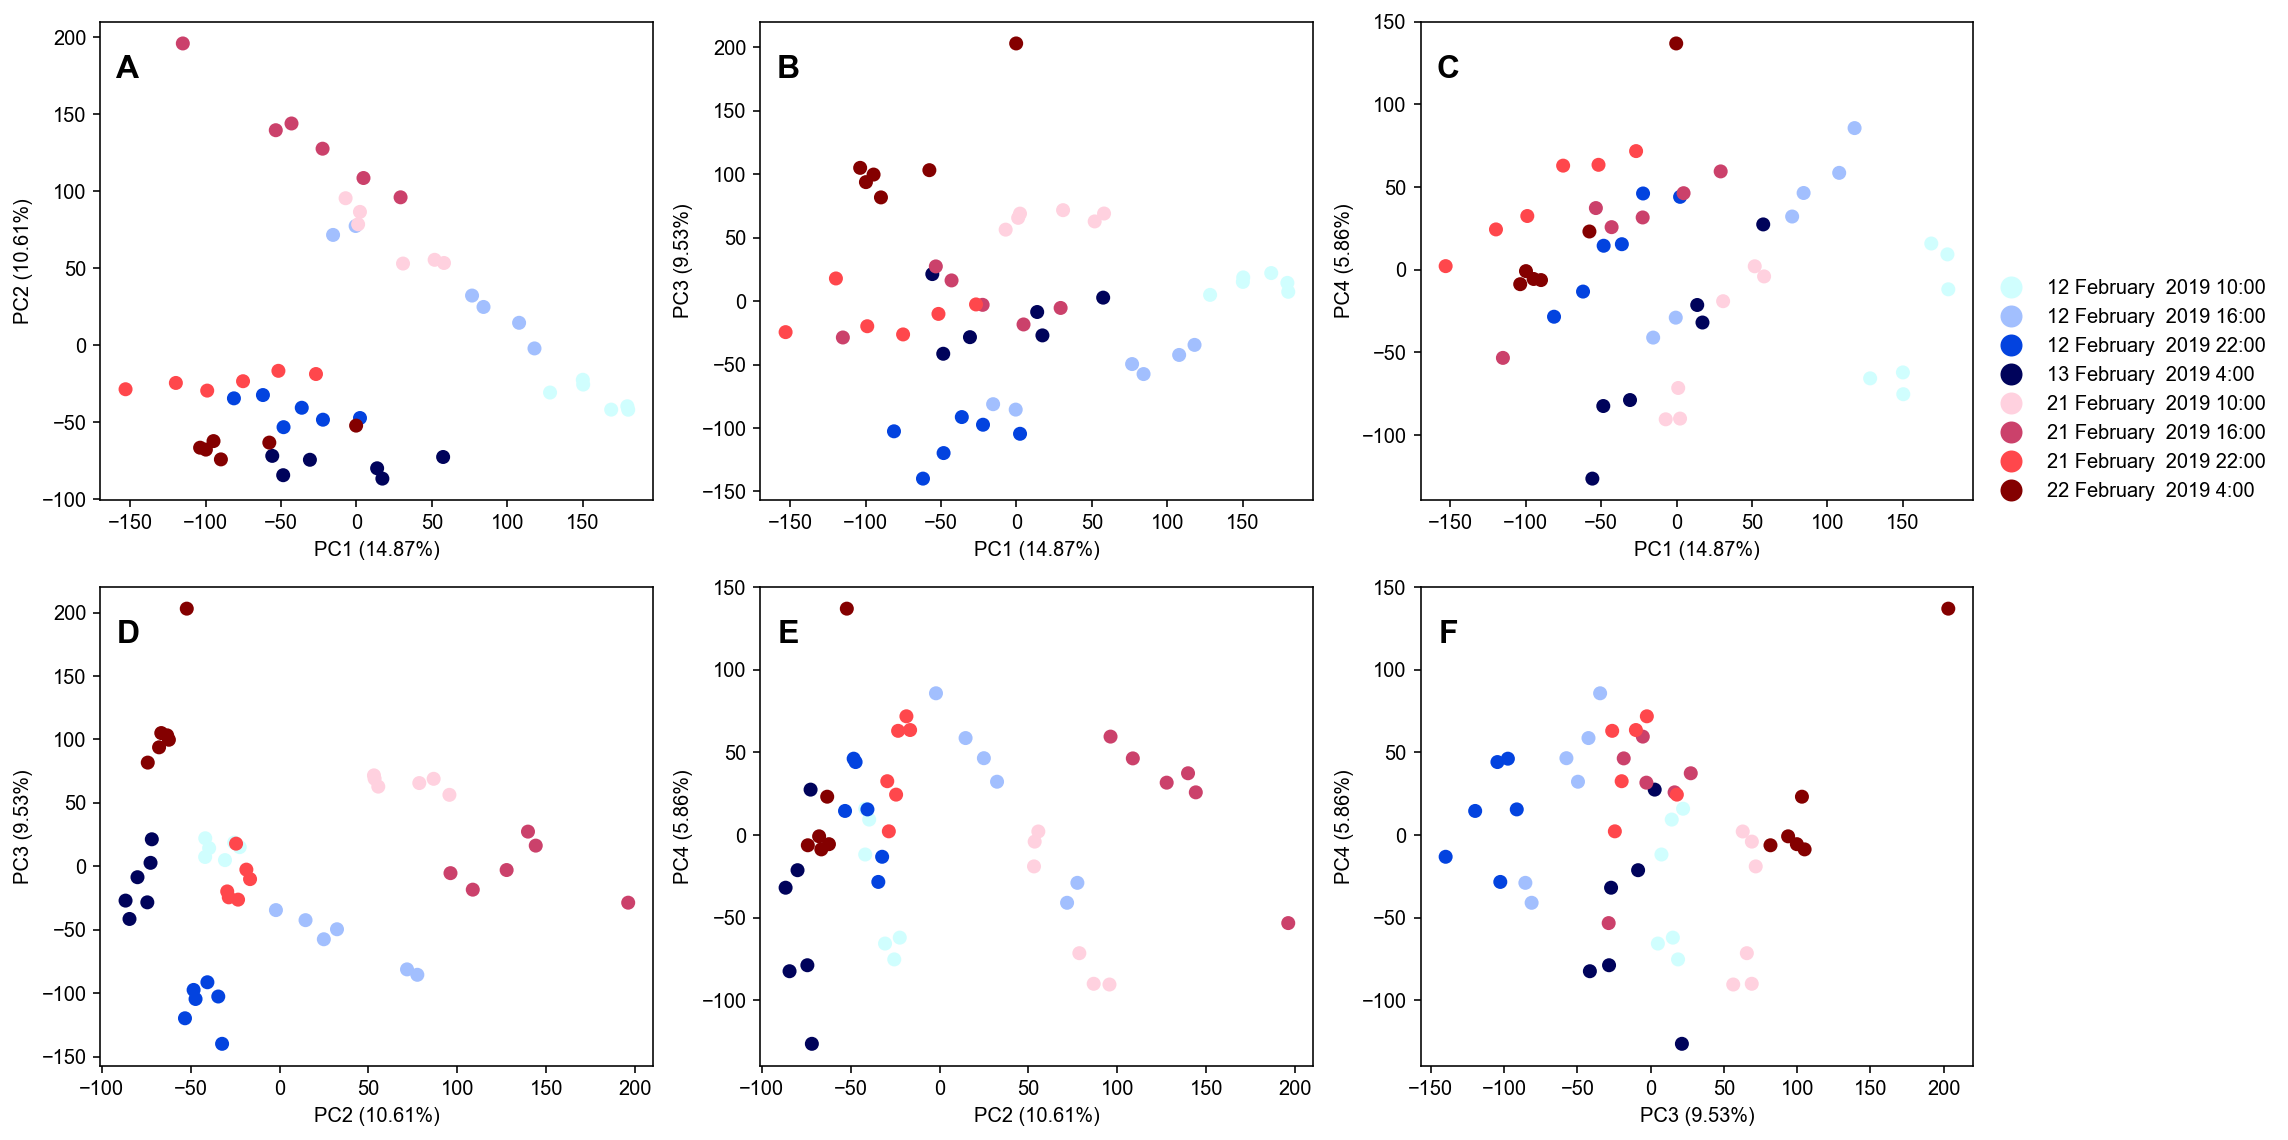

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16,8))

j=0
for i, (pcX,pcY) in enumerate(combinations(['PC1','PC2','PC3', 'PC4'], 2)):
    ax[j,i%3].scatter(x=kallisto_tpm_pca[pcX], y=kallisto_tpm_pca[pcY], c=kallisto_tpm_pca['color'])
    ax[j,i%3].set_xlabel("{} ({:2.2f}%)".format(pcX, kallisto_tpm_pca_config.explained_variance_ratio_[int(pcX[-1])-1]*100))
    ax[j,i%3].set_ylabel("{} ({:2.2f}%)".format(pcY, kallisto_tpm_pca_config.explained_variance_ratio_[int(pcY[-1])-1]*100))
    
    ax[j,i%3].text(0.05, 0.9, string.ascii_uppercase[i], ha='center', va='center', transform=ax[j,i%3].transAxes, size=16, weight='bold')
    
    if i%3==2:
        j+=1

handles = []
for key in metadict.keys():
    handle = mlines.Line2D([], [], color=metadict[key]['color'], marker='o', linestyle='None', markersize=10, label=key)
    handles.append(handle)
    
ax[0,2].legend(handles=handles, loc="upper left", frameon=False, bbox_to_anchor=(1, 0.5))
 
plt.tight_layout()

# Plotting transcript abundance.
Now I'll import the data we need, reshape it, and plot TPM-normalized abundance data for genes of interest. We'll need

1. Metadata
2. Count data from kallisto
3. Differential abundance stats from sleuth

**Note that `../Network-analysis/P-amilis-gene-norm-filt.WGCNA.csv` will be used for WGCNA. It requires a format where each library is a row and each gene is a column.**

In [12]:
metadata = pd.read_csv("../Abundance-analysis/P-amilis.metadata.csv")
sleuthdir = Path("/Users/iangilman/Dropbox/Drought-experiments/Drought_Experiment_3/Abundance-analysis/sleuth")
sleuthcounts_gm = pd.read_csv(str(sleuthdir / "P-amilis-sleuth-gene-norm-filt.csv"), index_col=0)
# Export for WGCNA
# sleuthcounts_gm.T.to_csv("../Network-analysis/P-amilis-gene-norm-filt.WGCNA.csv")

sleuthcounts_gm = sleuthcounts_gm.reset_index().melt(id_vars=["index"], value_vars=[c for c in sleuthcounts_gm.columns if c.startswith("P")])
sleuthcounts_gm = sleuthcounts_gm.rename({"index":"gene", "variable":"sample", "value":"tpm"}, axis=1)
sleuthcounts_gm = sleuthcounts_gm.merge(right=metadata.drop(labels="sample", axis=1), right_on="sequencer_name", left_on="sample").drop(labels="sample", axis=1)
# sleuthcounts_gm.to_csv("../Abundance-analysis/sleuth/P-amilis-genes-TPM-with-metadata.csv")
sleuthcounts_gm.head()

,gene,tpm,RNA_No,Collection_time,Acc_No,individual,genotype,color,hex_color,time_point,sequencer_name,treatment
0,FUN_000002,0.0,ISG_002,12 February 2019 10:00,AM01,1,P. amilis,xkcd:pale blue,#d0fefe,0,P-amilis_002_174_019,W
1,FUN_000003,0.0,ISG_002,12 February 2019 10:00,AM01,1,P. amilis,xkcd:pale blue,#d0fefe,0,P-amilis_002_174_019,W
2,FUN_000004,0.0,ISG_002,12 February 2019 10:00,AM01,1,P. amilis,xkcd:pale blue,#d0fefe,0,P-amilis_002_174_019,W
3,FUN_000005,0.0,ISG_002,12 February 2019 10:00,AM01,1,P. amilis,xkcd:pale blue,#d0fefe,0,P-amilis_002_174_019,W
4,FUN_000006,0.0,ISG_002,12 February 2019 10:00,AM01,1,P. amilis,xkcd:pale blue,#d0fefe,0,P-amilis_002_174_019,W


Pivot dataframe fore use below.

In [13]:
sleuthtpm = sleuthcounts_gm.pivot(index='sequencer_name', columns='gene', values="tpm")
sleuthtpm.reset_index(inplace=True)
sleuthtpm = sleuthtpm.rename_axis(None, axis=1).rename_axis(None, axis=0)
sleuthtpm = sleuthtpm.merge(right=amilis_metadata, on="sequencer_name")
sleuthtpm.head()

,sequencer_name,FUN_000002,FUN_000003,FUN_000004,FUN_000005,FUN_000006,FUN_000007,FUN_000008,FUN_000009,FUN_000010,...,FUN_053341,RNA_No,Collection_time,Acc_No,individual,genotype,color,hex_color,time_point,treatment
0,P-amilis_002_174_019,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.177899,ISG_002,12 February 2019 10:00,AM01,01,P. amilis,xkcd:pale blue,#d0fefe,0,W
1,P-amilis_004_150_043,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,ISG_004,12 February 2019 10:00,AM04,04,P. amilis,xkcd:pale blue,#d0fefe,0,W
2,P-amilis_007_114_079,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,ISG_007,12 February 2019 10:00,AM02,02,P. amilis,xkcd:pale blue,#d0fefe,0,W
3,P-amilis_009_185_008,1.371509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,ISG_009,12 February 2019 10:00,AM05,05,P. amilis,xkcd:pale blue,#d0fefe,0,W
4,P-amilis_010_173_020,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.312323,ISG_010,12 February 2019 10:00,AM03,03,P. amilis,xkcd:pale blue,#d0fefe,0,W


In [14]:
# sleuthtpm.to_csv("../Abundance-analysis/sleuth/P-amilis-TPM-with-metadata.csv", index=False)

### Load dataframes
Should be able to pick up analysis from here by loading the file below. The only difference between `sleuthcounts` and `sleuthtpm` is the pivot that reindexes `sleuthtpm` by sample. We're going to pick up an additional file here, `P-amilis-pathway-assignments.csv`, which contains the list of all of the genes related to photosynthesis.

In [15]:
sleuthcounts = pd.read_csv("../Abundance-analysis/sleuth/P-amilis-TPM-with-metadata.csv", index_col=0)
sleuth_dge = pd.read_csv("../Abundance-analysis/sleuth/P-amilis-sleuth-DEgenes.csv", index_col=0)
amilisPathways = pd.read_csv('../InDepth-Annotation-Pipeline/P-amilis-pathway-assignments.csv')

/Users/iangilman/miniconda3/envs/python3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [16]:
sleuthcounts.head()

,target_id,sample,est_counts,tpm,eff_len,len,transcript,gene,annotation,RNA_No,Collection_time,Acc_No,individual,genotype,color,hex_color,time_point,sequencer_name,treatment
0,FUN_000029-T1,P-amilis_002_174_019,15.245290,3.212883,159.462127,357,FUN_000029-T1,FUN_000029,unknown,ISG_002,12 February 2019 10:00,AM01,1,P. amilis,xkcd:pale blue,#d0fefe,0,P-amilis_002_174_019,W
1,FUN_000030-T1,P-amilis_002_174_019,4.355797,2.104214,69.565608,240,FUN_000030-T1,FUN_000030,unknown,ISG_002,12 February 2019 10:00,AM01,1,P. amilis,xkcd:pale blue,#d0fefe,0,P-amilis_002_174_019,W
2,FUN_000031-T1,P-amilis_002_174_019,6.533696,1.695626,129.492817,321,FUN_000031-T1,FUN_000031,unknown,ISG_002,12 February 2019 10:00,AM01,1,P. amilis,xkcd:pale blue,#d0fefe,0,P-amilis_002_174_019,W
3,FUN_000032-T1,P-amilis_002_174_019,0.000000,0.000000,428.284328,639,FUN_000032-T1,FUN_000032,unknown,ISG_002,12 February 2019 10:00,AM01,1,P. amilis,xkcd:pale blue,#d0fefe,0,P-amilis_002_174_019,W
4,FUN_000033-T1,P-amilis_002_174_019,19.601087,1.876342,351.062931,561,FUN_000033-T1,FUN_000033,unknown,ISG_002,12 February 2019 10:00,AM01,1,P. amilis,xkcd:pale blue,#d0fefe,0,P-amilis_002_174_019,W


For the purposes of plotting so many genes and gene families, I wrote two plotting functions within the script `helpers.py`. Here's an example of the first, `tpm_plot`, which plots a single target gene at a time.

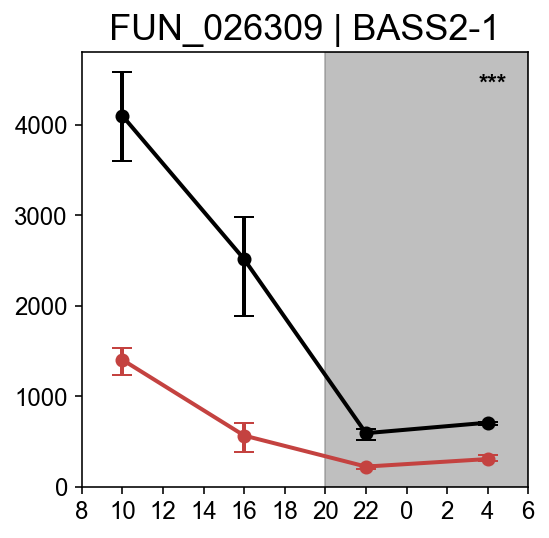

In [17]:
fig, ax = plt.subplots(figsize=(4,4))
tpm_plot(countsDF=sleuthcounts, column="gene", target="FUN_026309", sleuthDF=sleuth_dge, ax=ax, title="BASS2-1")

It plots the median TPM-normalized expression across biological relpicates, error bars showing IQR, and significance level (drought vs. well-watered) in the upper right; "*" = _q_ < 0.05, "\*\*" = _q_ < 0.01, "\*\*\*" = _q_ < 0.001, and "NS" = non-significant. 

The next is `multiTPMplot`, which plots a list of genes as subplots.

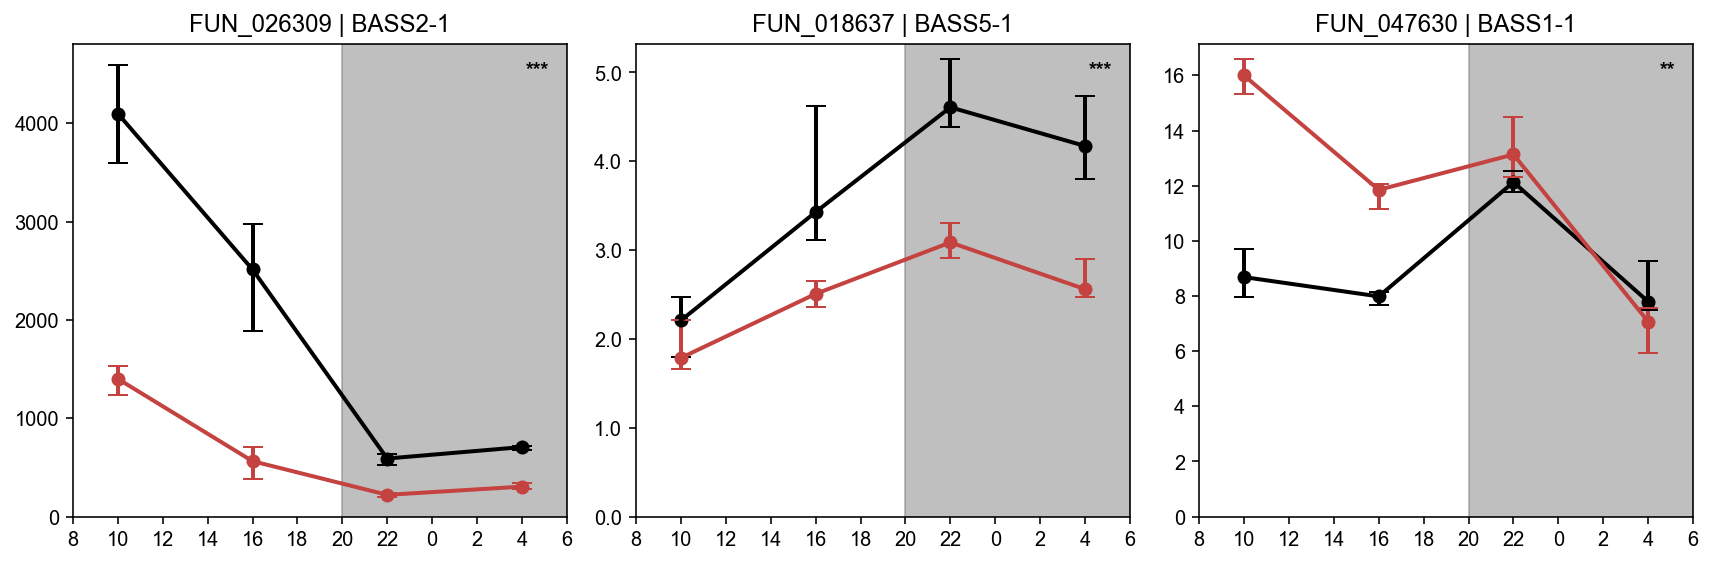

In [18]:
multiTPMplot(targets=amilisPathways[amilisPathways["Gene-family"]=='BASS'][["genemodel","Uniprot"]].sort_values(by="Uniprot"), 
             countsDF=sleuthcounts, countCol="gene", sleuthDF=sleuth_dge, save=False)

The commented out chunk below generates single plots for every gene family.

In [19]:
# for genefamily in amilisPathways["Gene-family"].unique():
#     if "/" in genefamily:
#         path = "../Figures/TPM-plots/P-amilis.{}.TPM.pdf".format(str(genefamily).replace("/","-"))
#     else:
#         path = "../Figures/TPM-plots/P-amilis.{}.TPM.pdf".format(genefamily)
#     multiTPMplot(targets=amilisPathways[amilisPathways["Gene-family"]==genefamily][["genemodel","Uniprot"]].sort_values(by="Uniprot"), 
#              countsDF=sleuthcounts, countCol="gene", sleuthDF=sleuth_dge, save=True, path=path, dpi=300)

and the next few blocks generate supplementary material figure S2, the TPM-normalized abundance of all genes mentioned in the manuscript.

In [20]:
supp_genes = pd.read_csv("../Figures/TPM-plots/genes-in-paper.csv", header=None, names=["gene-family"])
figS2data = amilisPathways[amilisPathways["Gene-family"].isin(supp_genes["gene-family"].values)]
figS2data = figS2data[figS2data["genemodel"].isin(sleuth_dge["target_id"].values)]

In [21]:
# multiTPMplot(targets=figS3data[["genemodel","Uniprot"]].sort_values(by="Uniprot"), 
#          countsDF=sleuthcounts, countCol="gene", sleuthDF=sleuth_dge, subplot_h=2, subplot_w=2, shape=(5,40), 
#          fontsize=8, titlefontsize=8, xticks="reduced", save=True, path="../Figures/Manuscript/Supplementary-figure-S2.pdf", dpi=300)

# _P. oleracea_
Now I'll repeat the steps above for _P. oleracea_

In [22]:
oleracea_metadata = rna_sample_data[rna_sample_data["genotype"]==("P. oleracea F")].reset_index(drop=True)
oleracea_metadata["sample"] = [s.replace("Florida", "F") for s in oleracea_metadata["sample"]]
  
POmetadict = Vividict()
for i,t in enumerate(oleracea_metadata['Collection_time'].unique()):
    POmetadict[t]['color'] = time_colors[i]
    POmetadict[t]['hex_color'] = time_hexcolors[i]
    POmetadict[t]['time_point'] = i
    
oleracea_metadata['color'] = [POmetadict[t]['color'] for t in oleracea_metadata['Collection_time']]
oleracea_metadata['hex_color'] = [POmetadict[t]['hex_color'] for t in oleracea_metadata['Collection_time']]
oleracea_metadata['time_point'] = [POmetadict[t]['time_point'] for t in oleracea_metadata['Collection_time']]
oleracea_metadata.head()

,RNA_No,Collection_time,Acc_No,sample,individual,genotype,color,hex_color,time_point
0,ISG_001,12 February 2019 10:00,OF05,P-oleracea-F_001,05,P. oleracea F,xkcd:pale blue,#d0fefe,0
1,ISG_005,12 February 2019 10:00,OF04,P-oleracea-F_005,04,P. oleracea F,xkcd:pale blue,#d0fefe,0
2,ISG_011,12 February 2019 10:00,OF06,P-oleracea-F_011,06,P. oleracea F,xkcd:pale blue,#d0fefe,0
3,ISG_013,12 February 2019 10:00,OF02,P-oleracea-F_013,02,P. oleracea F,xkcd:pale blue,#d0fefe,0
4,ISG_014,12 February 2019 10:00,OF03,P-oleracea-F_014,03,P. oleracea F,xkcd:pale blue,#d0fefe,0


In [23]:
kallisto_dir = Path("../farnam-drought-diff-exp/Kallisto/Portulaca-oleracea/no-filter-cluster98/")
sequencerNames = [s.stem for s in kallisto_dir.iterdir() if s.stem.startswith("P-oleracea")]
goodNames = []
goodSamples = []
for s in sequencerNames:
    for o in oleracea_metadata["sample"].values:
        if s.startswith(o):
            goodNames.append(s)
            goodSamples.append(o)
            continue

oleracea_metadata = oleracea_metadata[oleracea_metadata["sample"].isin(goodSamples)]
oleracea_metadata["sequencer_name"] = sorted(goodNames)
oleracea_metadata.reset_index(inplace=True, drop=True)

In [24]:
# oleracea_metadata.to_csv("../Abundance-analysis/P-oleracea-F.metadata.csv", index=False)
oleracea_metadata = pd.read_csv("../Abundance-analysis/P-oleracea-F.metadata.csv")

In [ ]:
POsleuthcounts = pd.read_csv(str(sleuthdir / "P-oleracea-sleuth-gene-norm-filt.csv"), index_col=0)
# Export for WGCNA
sleuthcounts_gm.T.to_csv("../Network-analysis/P-oleracea-unigene-norm-filt.WGCNA.csv")
# POsleuthcounts = POsleuthcounts.reset_index().melt(id_vars=["index"], value_vars=[c for c in POsleuthcounts.columns if c.startswith("P")])
# POsleuthcounts = POsleuthcounts.rename({"index":"unigene", "variable":"sequencer_name", "value":"tpm"}, axis=1)
# POsleuthcounts = POsleuthcounts.merge(oleracea_metadata, on="sequencer_name")
# POsleuthcounts.head()

In [26]:
# POsleuthcounts.to_csv("../Abundance-analysis/sleuth/P-oleracea-unigenes-TPM-with-metadata.csv", index=False)

In [27]:
POsleuthcounts = pd.read_csv("../Abundance-analysis/sleuth/P-oleracea-unigenes-TPM-with-metadata.csv")
POsleuth_dge = pd.read_csv("../Abundance-analysis/sleuth/P-oleracea-sleuth-DEgenes.csv", index_col=0)

In [28]:
oleraceaPathways = pd.read_csv('../InDepth-Annotation-Pipeline/P-oleracea-pathway-assignments.csv')
oleraceaPathways = oleraceaPathways.fillna("")
uniprots = []
for i,row in oleraceaPathways.iterrows():
    if row["Pamilis-uniprot"]=="":
        uniprots.append("po."+row["Poleracea-uniprot"])
    else:
        uniprots.append(row["Pamilis-uniprot"])
oleraceaPathways["Uniprot"] = uniprots
oleraceaPathways = oleraceaPathways.drop(["Athaliana-ortholog", "Athaliana-uniprot", "Poleracea-uniprot"], axis=1)
oleraceaPathways.head()

,transcript,Orthogroup,Pamilis-ortholog,Pamilis-uniprot,Gene-family,Block-description,Pathway,Localization,Uniprot
0,TRINITY_DN103395_c0_g1,OG0011322,FUN_048323,ADK2-1,ADK,Adenylate kinase 2,PEP generation,,ADK2-1
1,TRINITY_DN1529_c0_g1,OG0002519,FUN_046898,ADK3-1,ADK,Adenylate kinase 3,PEP generation,,ADK3-1
2,TRINITY_DN1795_c0_g4,OG0011322,FUN_048323,ADK2-1,ADK,Adenylate kinase 2,PEP generation,,ADK2-1
3,TRINITY_DN18870_c0_g1,OG0002519,FUN_011473,ADK3-2,ADK,Adenylate kinase 3,PEP generation,,ADK3-2
4,TRINITY_DN954_c0_g1,OG0006840,FUN_026031,ADK5-1,ADK,Adenylate kinase 5,PEP generation,,ADK5-1


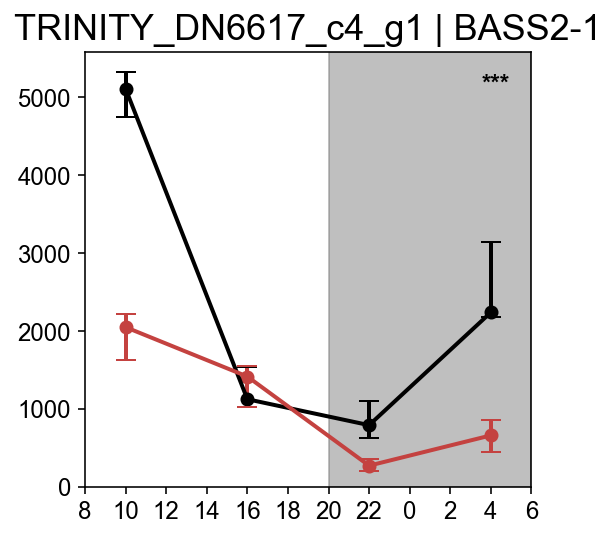

In [29]:
fig, ax = plt.subplots(figsize=(4,4))
tpm_plot(countsDF=POsleuthcounts, column="unigene", target="TRINITY_DN6617_c4_g1", sleuthDF=POsleuth_dge, ax=ax, title="BASS2-1")

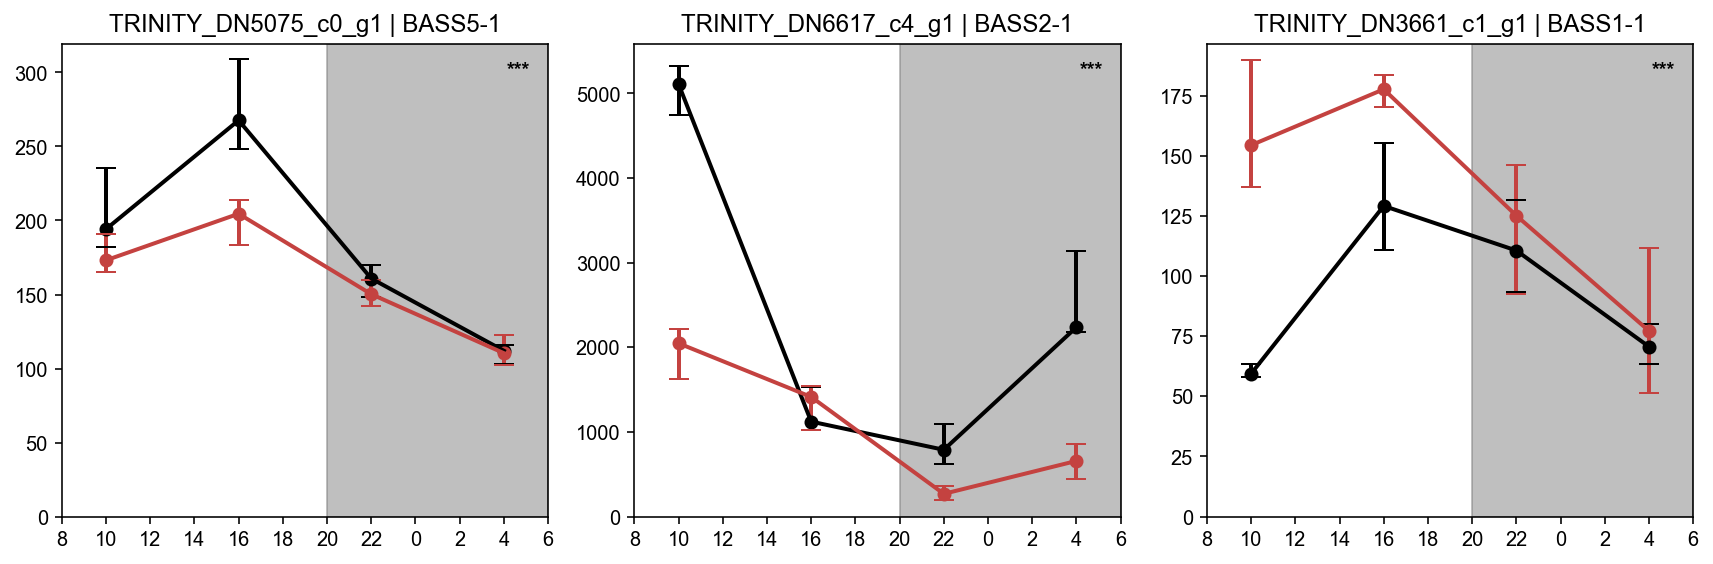

In [30]:
multiTPMplot(targets=oleraceaPathways[oleraceaPathways["Gene-family"]=="BASS"][["transcript","Uniprot"]].sort_values(by="Uniprot"), 
             countsDF=POsleuthcounts, countCol="unigene", sleuthDF=POsleuth_dge)

Like before, the next chunks of code create all TPM plots and those in figure S3.

In [31]:
# for genefamily in oleraceaPathways["Gene-family"].unique():
#     if "/" in genefamily:
#         path="../Figures/TPM-plots/P-oleracea.{}.TPM.pdf".format(str(genefamily).replace("/","-"))
#     else: 
#         path="../Figures/TPM-plots/P-oleracea.{}.TPM.pdf".format(genefamily)
#     multiTPMplot(targets=oleraceaPathways[oleraceaPathways["Gene-family"]==genefamily][["transcript","Uniprot"]].sort_values(by="Uniprot"), 
#              countsDF=POsleuthcounts, countCol="unigene", sleuthDF=POsleuth_dge, save=True, 
#              path=path, dpi=300)

In [32]:
figS3data = oleraceaPathways[oleraceaPathways["Gene-family"].isin(supp_genes["gene-family"].values)]
figS3data = figS3data[figS3data["transcript"].isin(POsleuth_dge["target_id"].values)]

In [33]:
# multiTPMplot(targets=figS3data[["transcript","Uniprot"]].sort_values(by="Uniprot"), 
#              countsDF=POsleuthcounts, countCol="unigene", sleuthDF=POsleuth_dge, subplot_h=2, subplot_w=2, shape=(5,52), twolinetitle=True,
#              fontsize=8, titlefontsize=8, xticks="reduced", save=True, path="../Figures/Manuscript/Supplementary-figure-S3.pdf", dpi=300)